In [144]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Task1 - Fourier Transform

![title](convolution.png)
Convolution formula from lecture (f is the image, h is the kernel)

In [4]:
# Implementation of convolution in spatial domain
def get_convolution(image, kernel):
    template_h, template_w = kernel.shape

    # By flipping the kernel we obtain the convolution using the correlation formula
    kernel = np.flipud(np.fliplr(kernel))

    # Prepare the result matrix
    result = np.zeros_like(image)
    # Pad the image to be able to slide the kernel at the edges
    image = np.pad(image.copy(), ((template_h//2, template_h//2), (template_w//2, template_w//2)), mode='constant')
    
    # Slide the kernel along the image
    # Patches of the image of template dimension are taken 
    for row in range(result.shape[0]):
        for col in range(result.shape[1]):
            patch = image[row:row+template_h, col:col+template_w]
            
            result[row, col] = np.sum(kernel * patch)
    
    return result

Mean absolute difference between cv2.filter2D and convolution: 0.0013


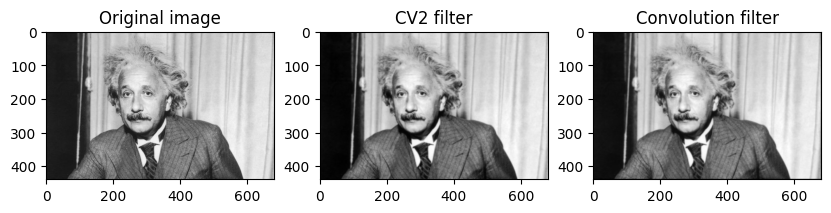

In [42]:
image = cv2.imread("./data/einstein.jpeg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title('Original image')
plt.imshow(image, cmap='gray')

kernel1D = cv2.getGaussianKernel(7, sigma=1)
kernel = kernel1D * kernel1D.T

# Sometimes it's useful to convert the RGB int values into 
image = image / 255.0

# Filter using cv2.filter2D
cv_result = cv2.filter2D(image, ddepth=-1, kernel=kernel)
plt.subplot(1,3,2)
plt.title('CV2 filter')
plt.imshow(cv_result, cmap='gray')

# Filter using convolution
conv_result = get_convolution(image, kernel)
plt.subplot(1,3,3)
plt.title('Convolution filter')
plt.imshow(conv_result, cmap='gray')

# Mean absolute difference between the blurred images:
mad = np.abs(cv_result - conv_result).mean()
print(f'Mean absolute difference between cv2.filter2D and convolution: {mad:.4f}')

## FFT - 1st version: the long and difficult way

In [26]:
# FFT on both kernel and image
fft_img = np.fft.fft2(image)
fft_kernel = np.fft.fft2(kernel)

try:
    fft_result = fft_img * fft_kernel
except Exception as e:
    print(f'Error: {e}')

Error: operands could not be broadcast together with shapes (440,680) (7,7) 


There is a mismatch of shapes! We need to pad the kernel to be the same size of the image

In [27]:
pad_width = image.shape[1] - kernel.shape[1]
pad_height = image.shape[0] - kernel.shape[0]

kernel_padded = np.pad(kernel, [(pad_height//2, pad_height//2), (pad_width//2, pad_width//2)])
if image.shape == kernel_padded.shape:
    print('Success!')
else:
    print("Error: shape doesn't match")
    kernel_padded = np.pad(kernel, [(pad_height//2+1, pad_height//2), (pad_width//2+1, pad_width//2)])
    print('Now shapes match!')


Error: shape doesn't match
Now shapes match!


Being even the dimensions of the image and odd the kernel, we need to add 1 left (or right) and up (or down)

In [28]:
fft_kernel = np.fft.fft2(kernel_padded)

try:
    fft_result = fft_img * fft_kernel
except Exception as e:
    print(f'Error: {e}')

Now there is no error! Let's print the result

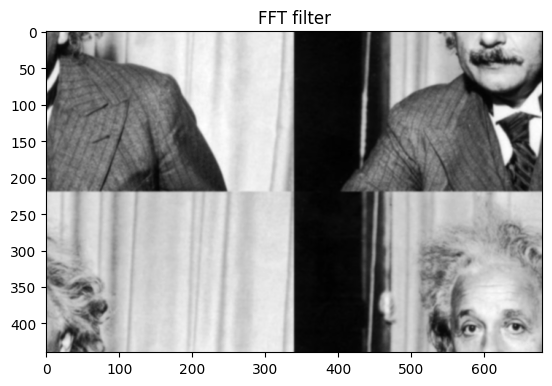

In [29]:
# First we need to do the inverse FFT and then take only the real values
ifft_result = np.fft.ifft2(fft_result).real

plt.title('FFT filter')
plt.imshow(ifft_result, cmap='gray')

There is something wrong! There is a shift!
Let's look at the frequency response of the gaussian kernel. The Fourier transform of a Gaussian signal should be a Gaussian signal as well

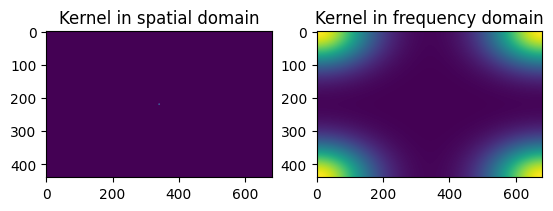

In [30]:
plt.subplot(1,2,1)
plt.title('Kernel in spatial domain')
plt.imshow(kernel_padded)
plt.subplot(1,2,2)
plt.title('Kernel in frequency domain')
plt.imshow(abs(np.fft.fft2(kernel_padded)))

The Gaussian is shifted because of the particular implementation of fft in numpy. This is why in numpy library itself there is the solution.

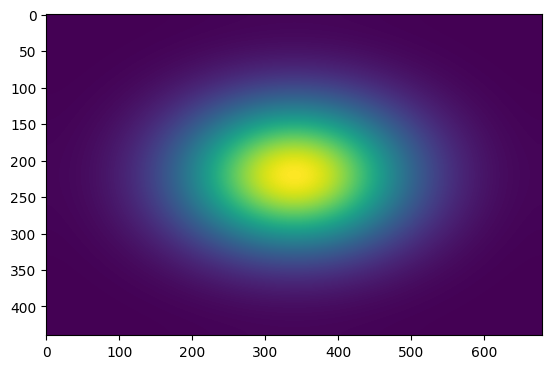

In [31]:
kernel_freq = np.fft.fft2(kernel_padded)
kernel_freq = np.fft.fftshift(kernel_freq)
plt.imshow(abs(kernel_freq))

Now we can fix the issue of shifting

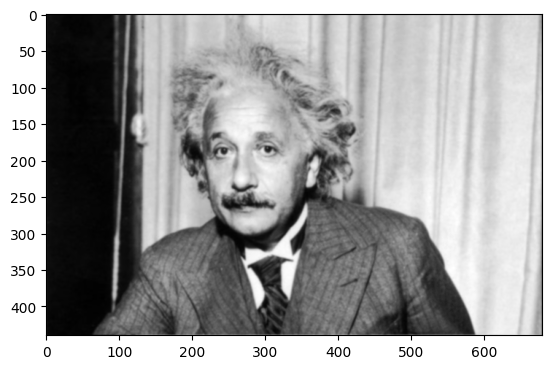

In [36]:
fft_result_shift = np.fft.fftshift(ifft_result)

plt.imshow(np.abs(fft_result_shift), cmap='gray')

## FFT - 2nd version: the very easy way

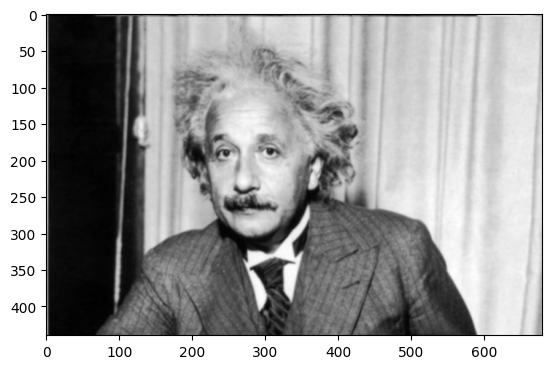

In [67]:
ff_img = np.fft.fft2(image)
# The 's' parameter both handle the padding of the kernel and the shifting problem!
ff_kernel = np.fft.fft2(kernel, s=image.shape)

fft_result = ff_img * ff_kernel
fft_result = np.fft.ifft2(fft_result)
plt.imshow(np.abs(fft_result), cmap='gray')

## Are all the results the same/similar?

In [68]:
print(f'CV vs Conv: {np.abs((conv_result - cv_result)).mean()}')
print(f'CV vs FFT (hard way): {np.abs((fft_result_shift - cv_result)).mean()}')
print(f'CV vs FFT (easy way): {np.abs((fft_result - cv_result)).mean()}')

CV vs Conv: 0.00130637569730189
CV vs FFT (hard way): 0.0012048019209520819
CV vs FFT (easy way): 0.045742470005038324


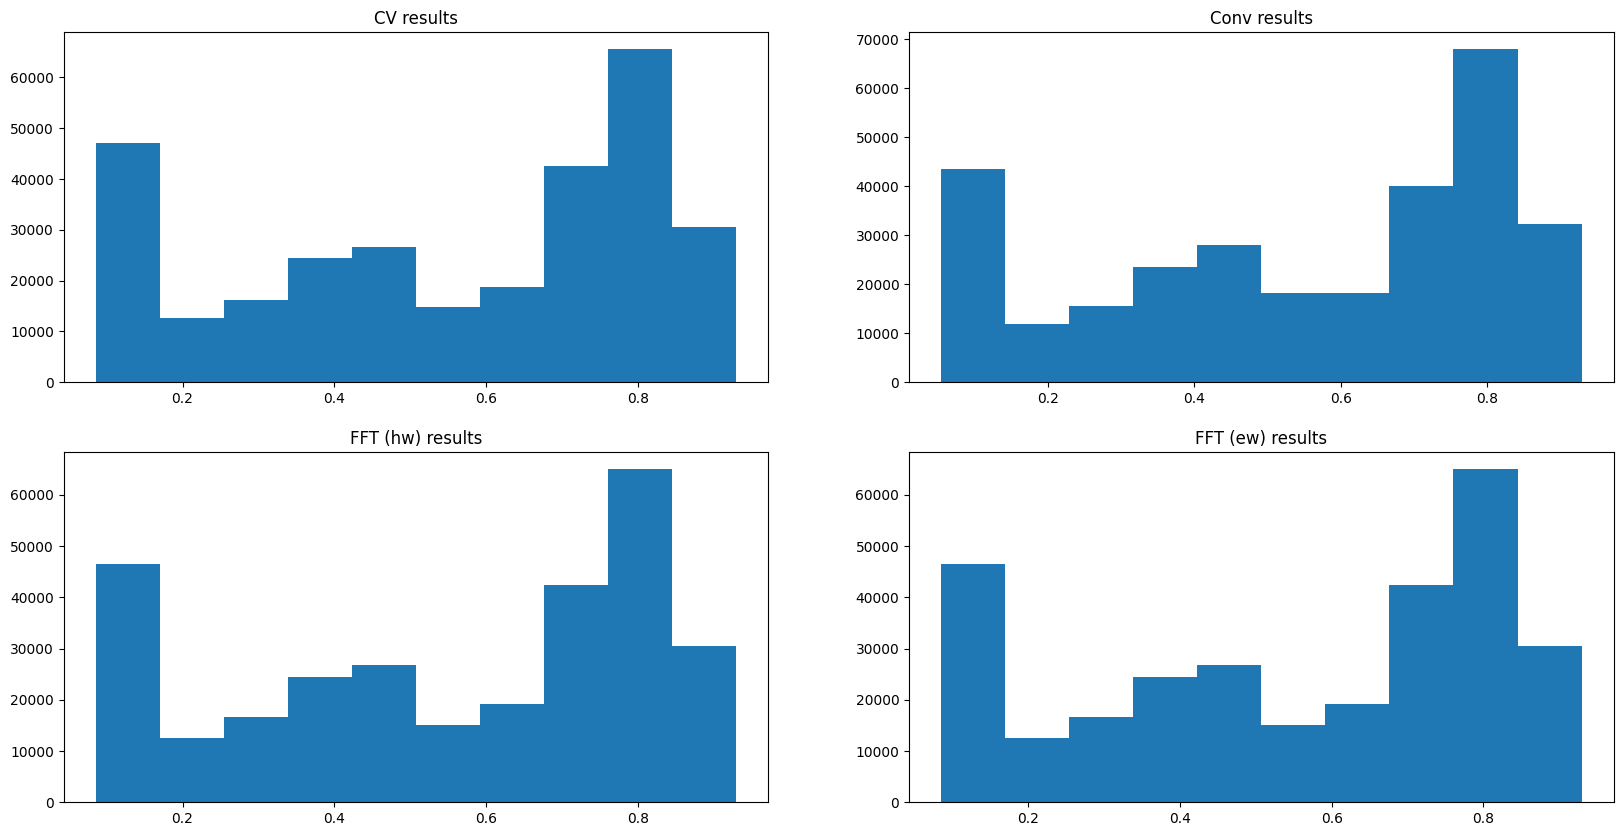

In [64]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('CV results')
_ = plt.hist(cv_result.reshape(-1))
plt.subplot(2,2,2)
plt.title('Conv results')
_ = plt.hist(conv_result.reshape(-1))
plt.subplot(2,2,3)
plt.title('FFT (hw) results')
_ = plt.hist(fft_result_shift.reshape(-1))
plt.subplot(2,2,4)
plt.title('FFT (ew) results')
_ = plt.hist(fft_result.reshape(-1))

# Task 2 - NCC

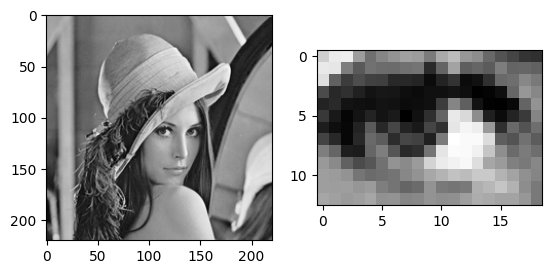

In [99]:
image = cv2.imread("./data/lena.png", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("./data/eye.png", cv2.IMREAD_GRAYSCALE)

# Convert RGB int to float in range [0,1]
image = image / 255.0
template = template / 255.0

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(template, cmap='gray')
plt.show()

![title](ncc.png)

In [115]:
def normalized_cross_correlation(image, template):
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=float
    )
    
    template_mean = np.mean(template)
    
    # Like the convolution before, but now subtracting the mean of every patch
    for row in range(result.shape[0]):
        for col in range(result.shape[1]):
            patch = image[row:row+template_h, col:col+template_w]
            patch_mean = np.mean(patch)

            norm = np.sqrt(
                np.sum(np.power(template - template_mean, 2))
                * np.sum(np.power(patch - patch_mean, 2))
            )
            norm = max(norm, 1e-8)
            
            result[row, col] = np.sum((template - template_mean) * (patch - patch_mean)) / norm
    
    return result

![title](ssd.png)

In [73]:
def ssd(image, template):
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=float
    )
    
    for row in range(result.shape[0]):
        for col in range(result.shape[1]):
            patch = image[row:row+template_h, col:col+template_w]

            result[row, col] = np.sum(np.power(patch - template, 2))
    
    return result

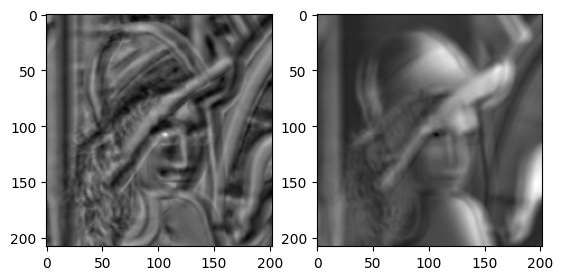

In [100]:
result_ncc = normalized_cross_correlation(image, template)
result_ssd = ssd(image, template)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(result_ncc, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(result_ssd, cmap='gray')
plt.show()

In [101]:
def draw_rectangle_at_matches(image, template_h, template_w, matches):
    matches = zip(matches[0], matches[1])
    for match in matches:
        cv2.rectangle(
            image,
            (match[1], match[0]),
            (match[1] + template_w, match[0] + template_h),
            0,
        )
    return image

There are two differences in using SSD and NCC:
- To find the match with SSD you need to use the minimum value, with NCC you need the maximum
- NCC is `normalized` and its values are in [0,1], while SSD is not normalized

So to find a significant threshold for SSD we'll normalize it

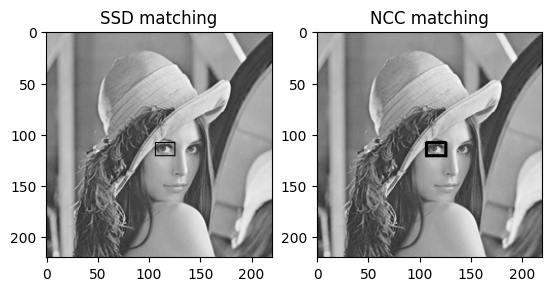

In [105]:
result_ssd_norm = (result_ssd - result_ssd.min())
result_ssd_norm /= result_ssd_norm.max()
threshold = 0.01
detections = np.where(result_ssd_norm < threshold)
ssd_rectangle = draw_rectangle_at_matches(image.copy(), template.shape[0], template.shape[1], detections)

threshold = 0.7
detections = np.where(result_ncc >= threshold)
ncc_rectangle = draw_rectangle_at_matches(image.copy(), template.shape[0], template.shape[1], detections)

plt.subplot(1,2,1)
plt.title('SSD matching')
plt.imshow(ssd_rectangle, cmap="gray")
plt.subplot(1,2,2)
plt.title('NCC matching')
plt.imshow(ncc_rectangle, cmap="gray")

## SSD and NCC with intensity change

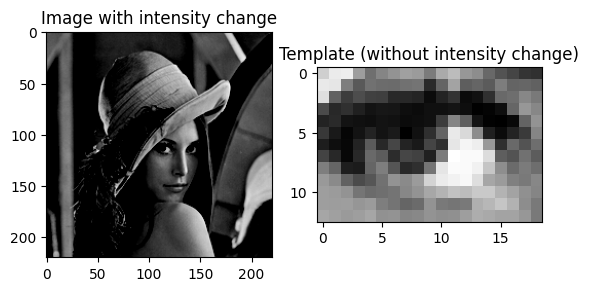

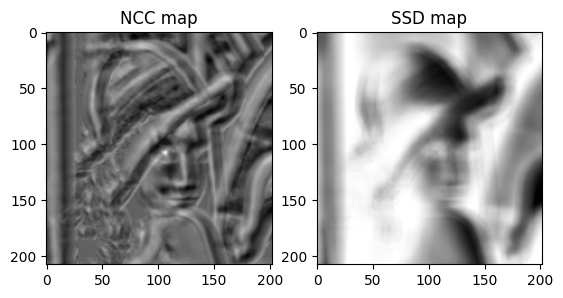

In [116]:
image = cv2.imread("./data/lena.png", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("./data/eye.png", cv2.IMREAD_GRAYSCALE)

image = image / 255.0
template = template / 255.0

image = (image - 0.5).clip(min=0)

plt.figure()
plt.subplot(1,2,1)
plt.title('Image with intensity change')
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title('Template (without intensity change)')
plt.imshow(template, cmap='gray')
plt.show()

result_ncc = normalized_cross_correlation(image, template)
result_ssd = ssd(image, template)

plt.figure()
plt.subplot(1,2,1)
plt.title('NCC map')
plt.imshow(result_ncc, cmap='gray')
plt.subplot(1,2,2)
plt.title('SSD map')
plt.imshow(result_ssd, cmap='gray')
plt.show()

As we can already see, NCC map is very similar to the previous one, while the SSD is different. We could have imagined it because NCC is invariant to intensity changes, while SSD is not. 

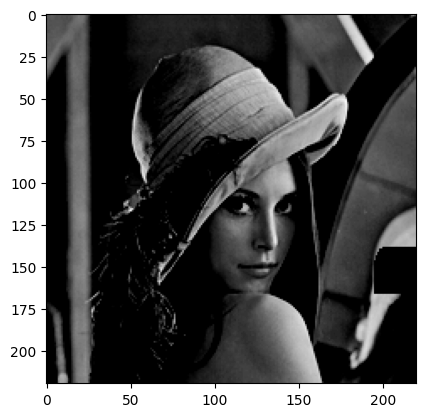

In [117]:
result_ssd_norm = (result_ssd - result_ssd.min())
result_ssd_norm /= result_ssd_norm.max()
threshold = 0.01
detections = np.where(result_ssd_norm < threshold)
result = draw_rectangle_at_matches(image.copy(), template.shape[0], template.shape[1], detections)
plt.imshow(result, cmap="gray")

As proof, the match in SSD is not found, while in NCC...

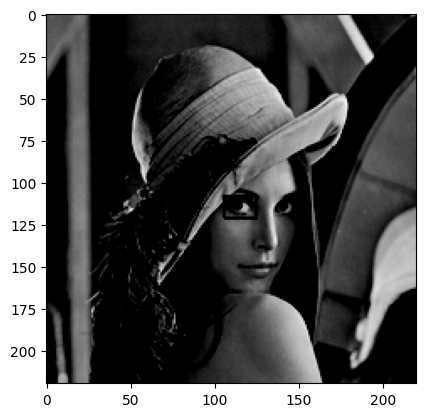

In [118]:
threshold = 0.7
detections = np.where(result_ncc >= threshold)
result = draw_rectangle_at_matches(image.copy(), template.shape[0], template.shape[1], detections)
plt.imshow(result, cmap="gray")

Yes! The match is still perfect here

# Task 3 - Gaussian Pyramid

In [119]:
def build_gaussian_pyramid_opencv(image, num_levels):
    result = []
    result.append(image)
    for _ in range(num_levels):
        image = cv2.pyrDown(image)
        result.append(image)
    return result


def build_gaussian_pyramid(image, num_levels):
    sigma = 1.0
    result = []
    result.append(image)
    for _ in range(num_levels):
        # Blur and then downsampling
        blurred_image = cv2.GaussianBlur(image, ksize=(5,5), sigmaX=sigma)
        image = blurred_image[0::2, 0::2]
        result.append(image)

    return result

We don't want to run NCC on every patch of every level, because this will be time consuming and will defeat the purpose of having the Gaussian pyramid.
We start from the coarsed level, with lower details, and find the most probable patches where the template could be. Then, in the higher levels of the pyramid, we will run NCC `only` on the most probable patches of the previous level. In this way the computation is much faster than running NCC completely on the full resolution image 

In [120]:
def template_matching_multiple_scales(pyramid_image, pyramid_template, show=False):
    threshold = 0.7
    window_size = 5
    
    # Reverse the pyramids, we start from the lowest resolution
    pyramid_image = pyramid_image[::-1]
    pyramid_template = pyramid_template[::-1]
    
    # Run NCC on the lowest resolution level, to find the most probable patches
    similarity_map = normalized_cross_correlation(pyramid_image[0], pyramid_template[0])
    
    if show:
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(pyramid_image[0], cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pyramid_template[0], cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(similarity_map, cmap="gray")
    
    # Refine the initial prediction by running NCC on the patches found on previous level 
    for i in range(1, len(pyramid_image)):
        # Matches are the pixel where, in the previous level, the probability (of match) was higher
        matches = np.where(similarity_map >= threshold)
        matches = zip(matches[0], matches[1])
        
        similarity_map = np.zeros_like(pyramid_image[i])        
        
        for match in matches:       
            # Match the location in the higher scale image 
            match = [x*2 for x in match]  

            # We take a larger window wrt the patch, but we make sure it doesnt' go over the limits
            top_left = max(match[0]-window_size, 0), max(match[1]-window_size, 0)

            match[0] += pyramid_template[i].shape[0]
            match[1] += pyramid_template[i].shape[1]

            bottom_right = min(match[0]+window_size, pyramid_image[i].shape[0]), min(match[1]+window_size, pyramid_image[i].shape[1])

            patch = pyramid_image[i][
                top_left[0]:bottom_right[0], 
                top_left[1]:bottom_right[1]
            ]
            
            # Then we run the NCC only in the patch
            similarity_ncc = normalized_cross_correlation(patch, pyramid_template[i])
            # The dimension of similarity_ncc are lower than the patch
            similarity = np.zeros_like(patch)
            similarity[:similarity_ncc.shape[0], :similarity_ncc.shape[1]] = similarity_ncc

            previous_similarity_map = similarity_map[
                top_left[0]:bottom_right[0], 
                top_left[1]:bottom_right[1]
            ]
            # Find where the similarity is increased compared to previous matches
            mask = similarity > previous_similarity_map

            similarity_map[
                top_left[0]:bottom_right[0], 
                top_left[1]:bottom_right[1]
            ] = mask*similarity + (1-mask)*previous_similarity_map

        if show:
            plt.figure(figsize=(10,10))
            plt.subplot(1,3,1)
            plt.imshow(pyramid_image[i], cmap='gray')
            plt.subplot(1,3,2)
            plt.imshow(pyramid_template[i], cmap='gray')
            plt.subplot(1,3,3)
            plt.imshow(similarity_map, cmap="gray")
    
    return similarity_map

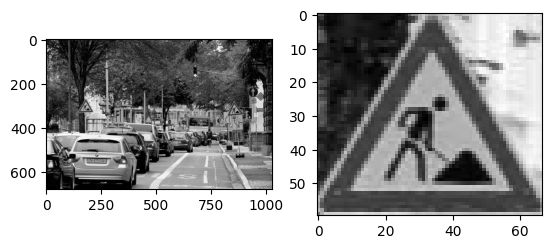

In [121]:
image = cv2.imread("./data/traffic.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("./data/traffic-template.png", cv2.IMREAD_GRAYSCALE)

# Convert image and template to float
image = image / 255.0
template = template / 255.0

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(template, cmap='gray')
plt.show()

In [122]:
cv_pyramid = build_gaussian_pyramid_opencv(image, 4)
cv_pyramid_template = build_gaussian_pyramid_opencv(template, 4)

my_pyramid = build_gaussian_pyramid(image, 4)
my_pyramid_template = build_gaussian_pyramid(template, 4)

Here's a plot of the levels of the pyramid (level 0 is the original image)

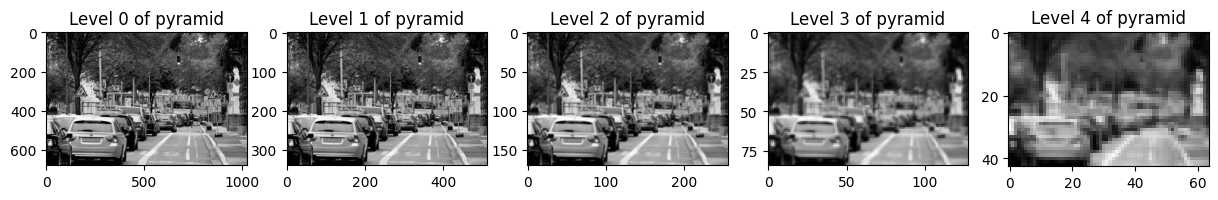

In [124]:
plt.figure(figsize=(15,15))
for i, mp in enumerate(my_pyramid):
    plt.subplot(1,5,i+1)
    plt.title(f'Level {i} of pyramid')
    plt.imshow(mp, cmap='gray')

In [125]:
for i, img in enumerate(my_pyramid):
    if i == 0:
        continue  # level 0 is the image itself.
    print(f"Level {i} difference: {np.abs(img - cv_pyramid[i]).mean()}")

Level 1 difference: 0.001922718872654587
Level 2 difference: 0.002034774266737555
Level 3 difference: 0.002196630781283203
Level 4 difference: 0.002458130272091054


### Timing template matching

In [126]:
import time

start = time.time()
similarity_map_wo_pyramid = normalized_cross_correlation(image, template)
elapsed = time.time()
print(f"Time matching WITHOUT pyramid: {(elapsed - start):4f}s")

Time matching WITHOUT pyramid: 48.908026s


In [127]:
start = time.time()
similarity_map = template_matching_multiple_scales(my_pyramid, my_pyramid_template)
elapsed = time.time()
print(f"Time matching WITH pyramid: {elapsed - start:4f}s")

Time matching WITH pyramid: 1.025221s


Let's see if the algorithm still found the template in the right position

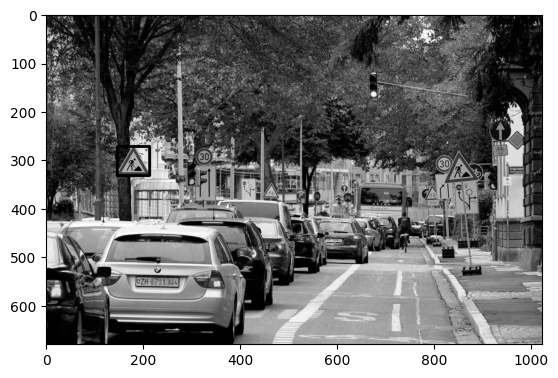

In [134]:
detections = np.where(similarity_map > 0.7)
rectangle = draw_rectangle_at_matches(image.copy(), template.shape[0], template.shape[1], detections)
plt.imshow(rectangle, cmap='gray')

The time difference in time is huge! We can now confirm that Gaussian pyramid is faster

# Task 4 - Edges

### Load image

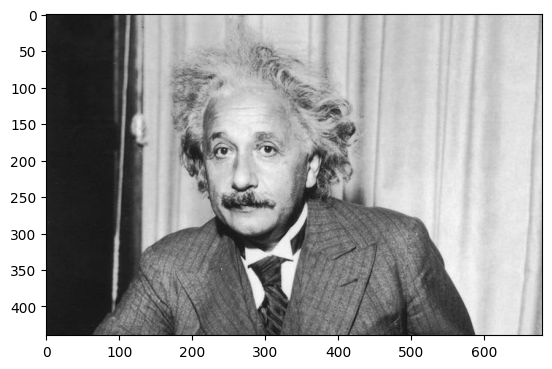

In [135]:
image = cv2.imread('./data/einstein.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = image / 255.0

### Weight of derivative of Gaussian

![title](gauss2d.png)

These are the partial derivatives:


![title](derivative.png)

In [136]:
def get_exponent(x, y, sigma):
    return -1 * (x**2 + y**2) / (2 * sigma**2)

# Derivative of 2D Gaussian
def get_derivative_of_gaussian_kernel(size, sigma):
    assert size > 0 and size % 2 == 1 and sigma > 0

    kernel_x = np.zeros((size, size))
    kernel_y = np.zeros((size, size))

    size_half = size // 2

    for i in range(size):
        y = i - size_half
        for j in range(size):
            x = j - size_half
            kernel_x[i, j] = (
                -1
                * (x / (2 * np.pi * sigma**4))
                * np.exp(get_exponent(x, y, sigma))
            )
            kernel_y[i, j] = (
                -1
                * (y / (2 * np.pi * sigma**4))
                * np.exp(get_exponent(x, y, sigma))
            )

    return kernel_x, kernel_y


In [137]:
kernel_x, kernel_y = get_derivative_of_gaussian_kernel(7, 2)

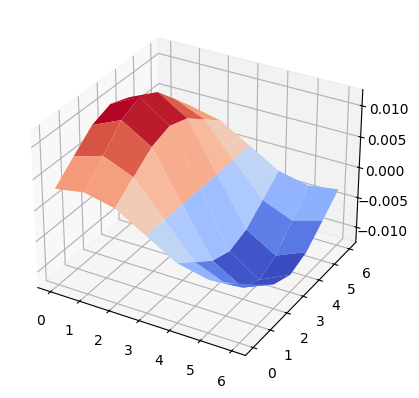

In [138]:
from matplotlib import cm
ax = plt.axes(projection="3d")

y = np.arange(len(kernel_x))
x = np.arange(len(kernel_x[0]))

(x ,y) = np.meshgrid(x,y)

ax.plot_surface(x,y,kernel_x, cmap=cm.coolwarm)
plt.show()

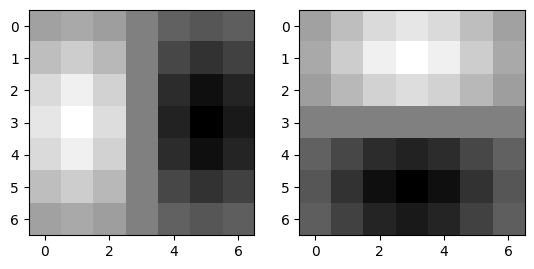

In [139]:
plt.subplot(1, 2, 1)
plt.imshow(kernel_x, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(kernel_y, cmap="gray")

### Get the edges with filtering

CV_32F is just the float representation

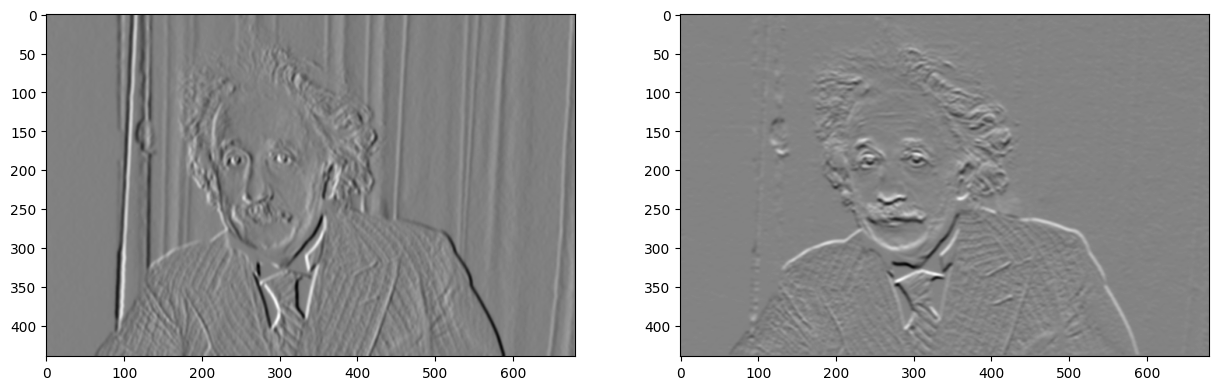

In [140]:
edge_x = cv2.filter2D(image, ddepth=-1, kernel=kernel_x)
edge_y = cv2.filter2D(image, ddepth=-1, kernel=kernel_y)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(edge_x, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(edge_y, cmap='gray')

### Compute edge magnitude and direction

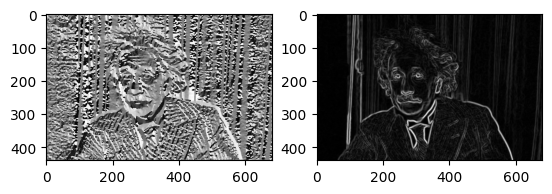

In [141]:
magnitude = np.arctan2(edge_y, edge_x)
direction = np.sqrt(np.power(edge_x, 2) + np.power(edge_y, 2))

plt.subplot(1,2,1)
plt.imshow(magnitude, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(direction, cmap='gray')

Code taken from https://medium.com/@rohit-krishna/coding-canny-edge-detection-algorithm-from-scratch-in-python-232e1fdceac7

There is also a useful explaination of how NMS works

Non maxima suppression works in this way: we consider the adjacent pixels along the gradient direction and take the one with greater intensity. The other pixels are setted to 0

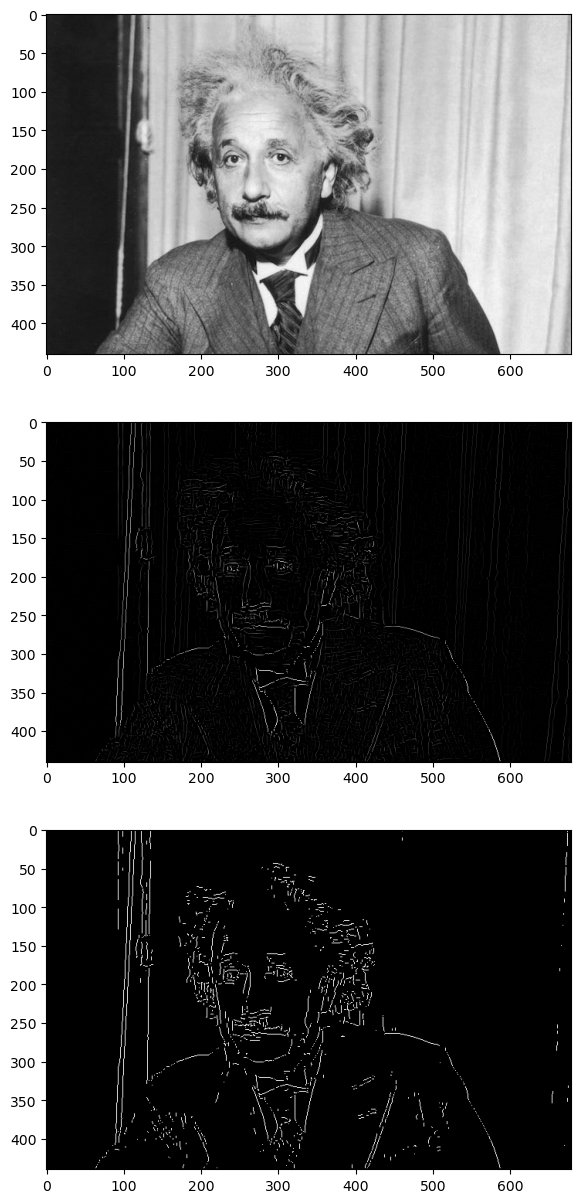

In [149]:
# Non-maximum suppression
def non_max_suppression(gradient_magnitude, gradient_direction):
    G = gradient_direction
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.int32)         # resultant image
    angle = gradient_magnitude * 180. / np.pi   # angle expressed in degree, max -> 180, min -> -180
    angle[angle < 0] += 180                     # max -> 180, min -> 0

    for i in range(1,M-1):
        for j in range(1,N-1):
            p = 255
            r = 255
            
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                r = G[i, j-1]
                p = G[i, j+1]

            elif (22.5 <= angle[i,j] < 67.5):
                r = G[i-1, j+1]
                p = G[i+1, j-1]

            elif (67.5 <= angle[i,j] < 112.5):
                r = G[i-1, j]
                p = G[i+1, j]

            elif (112.5 <= angle[i,j] < 157.5):
                r = G[i+1, j+1]
                p = G[i-1, j-1]

            if (G[i,j] >= p) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
            else:
                Z[i,j] = 0
    
    return Z

# Apply non-maximum suppression
gradient_direction = direction / direction.max() * 255 # Your quantized gradient direction image
suppressed_image = non_max_suppression(magnitude, gradient_direction)

# Optional: Apply thresholding to further refine edges
threshold = 50  # Adjust the threshold value as needed

# Display or save the results
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.imshow(image, cmap='gray')
plt.subplot(3,1,2)
plt.imshow(suppressed_image, cmap='gray')
plt.subplot(3,1,3)
plt.imshow(suppressed_image > threshold, cmap='gray')


### Sobel

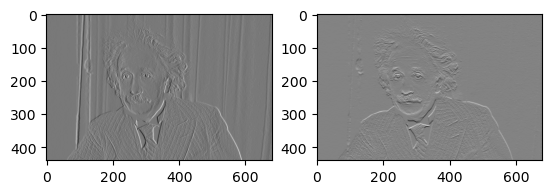

In [90]:
sobel_x = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
sobel_y = np.flip(sobel_x.T)

edge_sobel_x = cv2.filter2D(image, ddepth=-1, kernel=sobel_x)
edge_sobel_y = cv2.filter2D(image, ddepth=-1, kernel=sobel_y)

plt.subplot(1,2,1)
plt.imshow(edge_sobel_x, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(edge_sobel_y, cmap='gray')

In [81]:
np.mean(np.abs(edge_x - edge_sobel_x))

0.15157518834219352

# Task 5

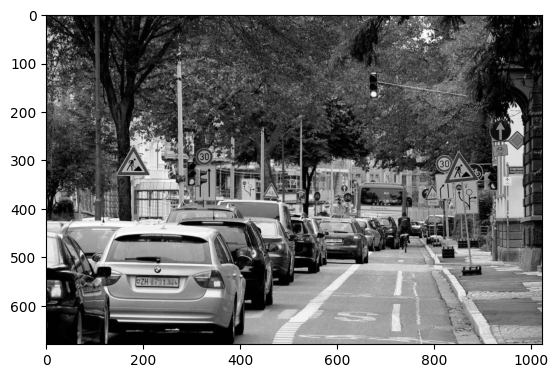

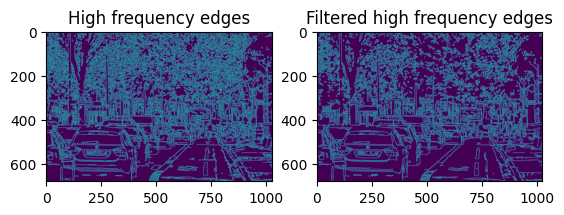

In [147]:
image = cv2.imread('./data/traffic.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(image, cmap='gray')

blur_image_7 = cv2.GaussianBlur(image, (7,7), 0.6)
blur_image_1 = cv2.GaussianBlur(image, (1,1), 0.6)
edge_canny_1 = cv2.Canny(image, 100, 250, 3)
edge_canny_7 = cv2.Canny(blur_image_7, 100, 250, 3)

plt.figure()
plt.subplot(1,2,1)
plt.title('High frequency edges')
plt.imshow(edge_canny_1)
plt.subplot(1,2,2)
plt.title('Filtered high frequency edges')
plt.imshow(edge_canny_7)

We have to take 1 - the edges because of how distance transform is implemented

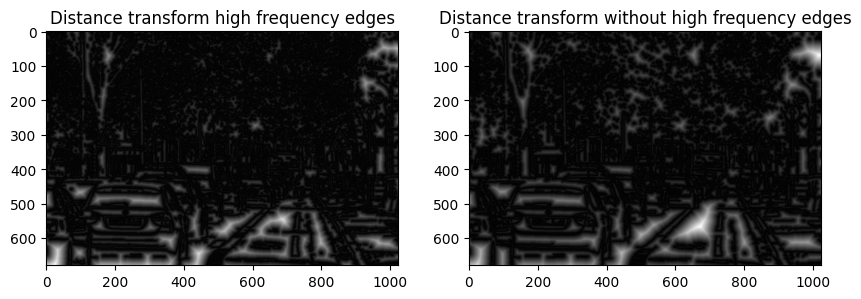

In [150]:
dt_result_cv_1 = cv2.distanceTransform(
    src=np.uint8((1 - edge_canny_1/255.0) * 255.0),
    distanceType=cv2.DIST_L2,
    maskSize=cv2.DIST_MASK_PRECISE,
)

dt_result_cv_7 = cv2.distanceTransform(
    src=np.uint8((1 - edge_canny_7/255.0) * 255.0),
    distanceType=cv2.DIST_L2,
    maskSize=cv2.DIST_MASK_PRECISE,
)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Distance transform high frequency edges')
plt.imshow(dt_result_cv_1, cmap='gray')

plt.subplot(1,2,2)
plt.title('Distance transform without high frequency edges')
plt.imshow(dt_result_cv_7, cmap='gray')

Value at (x,y) tells how far that position is from the nearest edge point (or other binary mage structure) 